# Modules

In [29]:
#Import all modules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import h5py as h5
from mayavi import mlab




In [30]:
#Needs to follow inline magick command
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 24
plt.rcParams['image.cmap'] = 'viridis'

# Parameters

In [31]:
energy = 709.42 #eV
h = 4.1357e-15 #Planck constant, eV s
c = 2.9979e18 #Angstroms per second
wavelength = h*c/energy #Angstrom
print("Wavelength [A]", wavelength)
distance=260 #sample-to-detector distance, mm
pixel_size = 0.0135 #[mm]
N = 2048 #Number of linear pixels in square detector
bin_factor = 8 #Factor by which to bin detector images

#Rebins data by a factor of [factor]
def rebin(arr, factor):
    shape = (4, 61, N//factor, factor,
             N//factor, factor)
    return arr.reshape(shape).mean(-1).mean(3)




Wavelength [A] 17.476833229962505


# Load Data

3.0
3.0
3.0
3.0
[55.299953 59.3      65.3      69.30004 ]
Theta array shape (61,)
Two-theta array shape (4,)
Data array shape (4, 61, 256, 256)


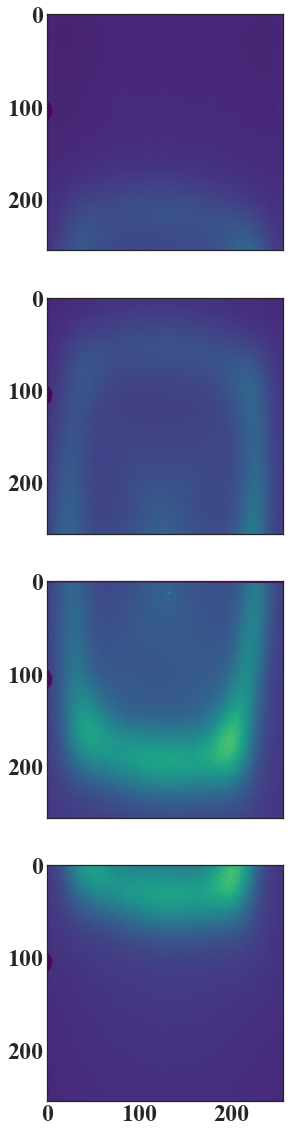

In [32]:
#scan_number = [125,126,127,128]
# scan_number = [147, 148, 149, 150]
scan_number = [187, 188, 189, 190]
two_theta_arr = np.empty(4,dtype = np.float32)
#theta_arr = np.empty(61)
data = np.empty((4,61,N,N),dtype = np.float32)
for i, scan in enumerate(scan_number):
    path='C:/Users/mast3/Desktop/UCSD/Research/Data/2019_12_Soleil/scan_0%d.nxs' %scan #Scan path
    f = h5.File(path,'r')
    datagroups = f['scan_0%d' %scan]
    exposure = datagroups['scan_data']['integration_times'][0]
    print(exposure)
    #print(datagroups['scan_data'].keys())
    data[i] = datagroups['scan_data']['data_16']
    two_theta_arr[i] = (datagroups['scan_data']['data_06'][0] + 41.3)*np.pi/180 #Rad, 41.3 addition needed to get actual value
    #print(datagroups['scan_data']['data_06'][:])
    if i==0:
        theta_arr = datagroups['scan_data']['data_07'][:]*np.pi/180
        
        
#Rebin data for faster visualization, flip along horizontal axis since data is apparently inverted and normalize to exposure time of 4s.
data = np.flip(rebin(data, bin_factor),axis=2)*4/exposure

#print(theta_arr*180/np.pi)
print(two_theta_arr*180/np.pi)
print("Theta array shape",theta_arr.shape)
print("Two-theta array shape",two_theta_arr.shape)
print("Data array shape",data.shape)
fig, ax = plt.subplots(4, sharex=True, figsize=(9,20))
for i in range(4):
    ax[i].imshow(data[3-i][30], vmin=0, vmax=13000)

# Map detector images to 3D reciprocal space

In [33]:
'''This cell takes a while to process all data, but only needs to be run once''';

##Map all images to reciprocal space




# """This is the way faster method using array broadcasting for mapping all detector images to reciprocal space. 
#     Only needs to be run once, results saved as .npy files at the end """;
# Overall shape is ((two_theta_values, theta_values, N, N))


Nbin = N//bin_factor

two_theta = two_theta_arr.reshape((4,1,1,1))
theta = theta_arr.reshape((1,61,1,1))
#Distance to senter of detector
#L = np.ones((1,1,N,N))

#Horizontal/vertical distances from center of detector
lx = np.arange(Nbin//2,-Nbin//2,-1).reshape((1,1,1,Nbin))*pixel_size*bin_factor 
ly = np.arange(Nbin//2,-Nbin//2,-1).reshape((1,1,Nbin,1))*pixel_size*bin_factor

#Angles in xz/yz planes; two_theta_eff is angle to particular detector row of pixels
two_theta_eff = np.arctan(ly/distance) + two_theta
gamma = np.arctan(lx/distance)

# print('Theta shape is ', theta.shape)
# print('Two_theta_eff shape is ',two_theta_eff.shape)
# print('Gamma shape is ', gamma.shape)

# plt.figure(figsize=(16,9))
# for tth in two_theta_eff:
#     plt.plot(tth.flatten()*180/np.pi)

L = np.sqrt(distance**2 + lx**2 + ly**2)
# print('L shape is ', L.shape)

# fig = plt.figure(figsize = (12,12))
# plt.title('Distance to pixel')
# plt.imshow(L[0][0])
# plt.colorbar()

phi_tot = np.arccos(np.cos(gamma)*np.cos(two_theta_eff))
# print('Phi_tot shape is ',phi_tot.shape)



# fig = plt.figure(figsize=(12,12))
# plt.title('Total deflection angle to pixel')
# plt.imshow(phi_tot[0][0]*180/np.pi)
# plt.colorbar()
q_tot = 4*np.pi*np.sin(phi_tot/2)/wavelength
print('q_tot shape is ',q_tot.shape)

QX = q_tot*np.sin(theta - two_theta_eff/2)*np.cos(gamma)
QZ = q_tot*np.cos(theta - two_theta_eff/2)*np.cos(gamma)
QY = q_tot*np.sin(gamma)*np.ones((1,61,1,1))

print('QX shape is ',QX.shape)

np.save('QX.npy',QX)
np.save('QY.npy',QY)
np.save('QZ.npy',QZ)
np.save('data.npy',data)



"""Attempt 2, not as clear/fast""";


# QX = np.zeros((4,61,N,N),dtype = np.float32)
# QY = np.zeros((4,61,N,N),dtype = np.float32)
# QZ = np.zeros((4,61,N,N),dtype = np.float32)

# for i in range(len(data)):
# # i=0
# # if True:
#     two_theta = two_theta_arr[i] #[rad]
#     for j in range(len(data[0])):
# #     j=0
# #     if True:
#         theta = theta_arr[j] #[rad]
        
#         #distance from center of detector, shape (N,) positive in top/left direction (increasing 2theta or qy)
#         l_det = np.arange(N//2,-N//2,-1)*pixel_size 
        
#         #effective two_theta based on vertical location on detector, shape (N,N) with equal values on each row
#         two_theta_eff = np.zeros((N,N)) + two_theta + np.arctan(l_det[:,None]/distance)
                
#         #angle away from center of detector in (qy) direction, shape (N,N) with equal values in each column
#         gamma = np.zeros((N,N)) + np.arctan(l_det/distance)
        
#         #distance from sample to each pixel on detector, shape (N,N). Uses broadcasting
#         L = np.sqrt(np.zeros((N,N)) + (distance**2) + l_det**2 + l_det[:,None]**2)

#         #Total diffraction angle to each pixel on detector, shape (N,N). 
#         #Note that l_det[:, None] has equal values on each row, but L does not.
#         phi_tot = np.arccos((distance*np.cos(two_theta) - l_det[:,None]*np.sin(two_theta))/L)
        
#         q_hat = np.array([np.sin(theta - two_theta_eff/2)*np.cos(gamma), np.sin(gamma), np.cos(theta - two_theta_eff/2)*np.cos(gamma)])
#         qin_hat = np.array([np.cos(theta), 0, -np.sin(theta)])
#         qout_hat = (q_hat.reshape((N,N,3))+ qin_hat) / np.linalg.norm(q_hat.reshape((N,N,3)) + qin_hat)

#         phi_tot_2 = np.arccos(np.dot(qout_hat, qin_hat))
        
#         #Total diffraction wavenumber, shape (N,N), [A^-1]
#         q_tot = 4*np.pi*np.sin(phi_tot/2)/wavelength 
        
#         #Components of q_tot, with qz perpendicular to sample and qy perpendicular to beam plane
#         QX[i][j] = q_tot*np.sin(theta - two_theta_eff/2)*np.cos(gamma)
#         QZ[i][j] = q_tot*np.cos(theta - two_theta_eff/2)*np.cos(gamma)
#         QY[i][j] = q_tot*np.sin(gamma)

# fig1=plt.figure()    
# plt.imshow(L)
# plt.colorbar()

# fig2=plt.figure()
# plt.imshow(phi_tot*180/np.pi)
# plt.colorbar()

# fig3=plt.figure()
# plt.imshow(phi_tot_2*180/np.pi)
# plt.colorbar()



        

   

"""This method works, but is really slow. Trying to instead do it with as few for-loops as possible,
   making better use of numpy arrays being way faster""";

# print(len(QX.flatten()))
# for i in range(len(data)):
#     two_theta = two_theta_arr[i] #[rad]

#     for j in range(len(data[0][0:10])):
#         theta = theta_arr[j] #[rad]
#         for row in range(N//4,N//2):
#             ly = (N/2 - row)*pixel_size #y distance from center of detector, positive above center [mm]
#             two_theta_eff = two_theta + np.arctan(ly/distance) #[rad]
#             for col in range(N//4,N//2):
#                 lx = (N/2 - col)*pixel_size #x distance from center of detector, positive in qy direction (into plane) [mm]
#                 gamma = np.arctan(lx/distance) #angle perpendicular to beam plane [rad]
#                 L = np.sqrt(distance**2 + lx**2 + ly**2) #[mm] #distance to particular pixel on detector [mm]

#                 phi_tot = np.arccos((distance*np.cos(two_theta) - ly*np.sin(two_theta))/L) #total angle of deflection of beam [rad]
#                 q_tot = 4*np.pi*np.sin(phi_tot/2)/wavelength #[A^-1]

#                 qx = q_tot*np.sin(theta - two_theta_eff/2)*np.cos(gamma)
#                 qz = q_tot*np.cos(theta - two_theta_eff/2)*np.cos(gamma)
#                 qy = q_tot*np.sin(gamma)

#                 QX[i][j][row-N//4][col-N//4] = qx
#                 QY[i][j][row-N//4][col-N//4] = qy
#                 QZ[i][j][row-N//4][col-N//4] = qz
                
                

                

q_tot shape is  (4, 1, 256, 256)
QX shape is  (4, 61, 256, 256)


In [34]:
#Tests

# npoints=10
# vertices = np.random.random([npoints, 3])
# print(vertices)

# x=np.arange(10)
# y=np.arange(10,20)
# z=np.arange(20,30)

# vertices = np.array([x,y,z]).reshape((10,3))
# print(vertices)

# Load processed data and generate volumetric plot

In [41]:
"""Large data, takes a few minutes to load""";

# QX = np.load('QX.npy')#[:,0,:,:]#[:,:,::16,::16]
# QY = np.load('QY.npy')#[:,0,:,:]#[:,:,::16,::16]
# QZ = np.load('QZ.npy')#[:,0,:,:]#[:,:,::16,::16]
# Intensity = np.load('data.npy')#[:,0,:,:]#[:,:,::16,::16]

print('Data loaded')


#Create mlab object containing data points

# src = mlab.pipeline.scalar_scatter(QX.flatten(), QY.flatten(), QZ.flatten(), Intensity.flatten())

#Extrapolate a scalar field object from data points

# field = mlab.pipeline.gaussian_splatter(src)
print('Field generated')

#Create grid for volumetric data

# xmin, xmax = np.min(QX.flatten()), np.max(QX.flatten())
# ymin, ymax = np.min(QY.flatten()), np.max(QY.flatten())
# zmin, zmax = np.min(QZ.flatten()), np.max(QZ.flatten())
# x, y, z = np.mgrid[xmin:xmax:64j, ymin:ymax:64j, zmin:zmax:128j]

#Intensity array at each point on grid
# s = mlab.pipeline.probe_data(field, x, y, z)
# np.save('Field_3.npy',s)
# print('Scalar field created')

s1 = np.load('Field_1.npy') #78K
s2 = np.load('Field_2.npy') #112K
s3 = np.load('Field_3.npy') #292K
diff = s3 - s1




#Time for the magic
mlab.pipeline.volume(mlab.pipeline.scalar_field(s3))
#mlab.axes()
#mlab.contour3d(diff)
mlab.volume_slice(diff, plane_orientation = 'z_axes')
mlab.show()





Data loaded
Field generated
